In [47]:
%matplotlib inline
import numpy as np
from scipy.integrate import solve_ivp
from parametres import Paras
from utilities import *
from initialisation import *
from odes import odes_scale_size
import matplotlib.pyplot as plt
from size_scaled_func import *
import datetime as dt
from simulation_func import *
import pandas as pd
import pickle as pkl
import os

# Running the Simulations


- Setting 25 species, 50 resources
- 100 simulations were performed

In [2]:
# Setting parametres
N = 100
M = 50
#assemblenum = 1
para = Paras(N, M)

In [3]:
# Store data
Rt_assemblies = []
Ct_assemblies = []
assemlies = 30
para_assemblies = []
time_assemblies = []

In [4]:
# Run simulation
start = dt.datetime.now()
for i in range(assemlies):
    Rt, Ct, t, para = sim_run(N, M, para, i, tstop=10e6, teval=10000)
    Rt_assemblies.append(Rt)
    Ct_assemblies.append(Ct)
    para_assemblies.append(para)
    time_assemblies.append(t)
    print(f'Asembly {i+1} complete, runtime:{dt.datetime.now()-start}') if (i+1) %5==0 else None

Asembly 5 complete, runtime:0:01:39.573000
Asembly 10 complete, runtime:0:03:19.669403
Asembly 15 complete, runtime:0:05:00.877972
Asembly 20 complete, runtime:0:06:42.641572
Asembly 25 complete, runtime:0:08:27.456213
Asembly 30 complete, runtime:0:10:12.914375


## Store the data

- Each Assembly will be stored in a dir called 'Abl_n' containing four files:
    - Resource concentration -- Abl_n_Rt.npy
    - Biomass concentration -- Abl_n_Ct.npy
    - Parametre -- Abl_n_Para.pkl
    - Time_series -- Abl_n_t.npy

In [49]:
for i in range(1, len(Ct_assemblies)+1):

    dir = f'..\Data\Abl_{i}'
    if not os.path.exists(dir):
        os.makedirs(dir) 

    with open(dir + f'\Abl_{i}_Ct.npy', 'wb') as f:
        np.save(f, Ct_assemblies[i-1])
    f.close()

    with open(dir + f'\Abl_{i}_Rt.npy', 'wb') as f:
        np.save(f, Rt_assemblies[i-1])
    f.close()

    with open(dir + f'\Abl_{i}_t.npy', 'wb') as f:
        np.save(f, time_assemblies[i-1])
    f.close()

    with open(dir + f'\Abl_{i}_Para.pkl', 'wb') as f:
        pkl.dump(para_assemblies[i-1], f)
    f.close()


# Analysis

## Plot final abundance for each assembly and species
- Choose S communities
- S= 5

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
S = 5

In [7]:
C5 = Ct_assemblies[0:S]
abundance25 = np.empty((N, S))
for i, assembly in enumerate(C5):
    abundance25[:, i] = assembly[:, -1]
abundance25 = abundance25/np.sum(abundance25, axis=0)

Text(0.5, 181.33333333333331, 'Simulations')

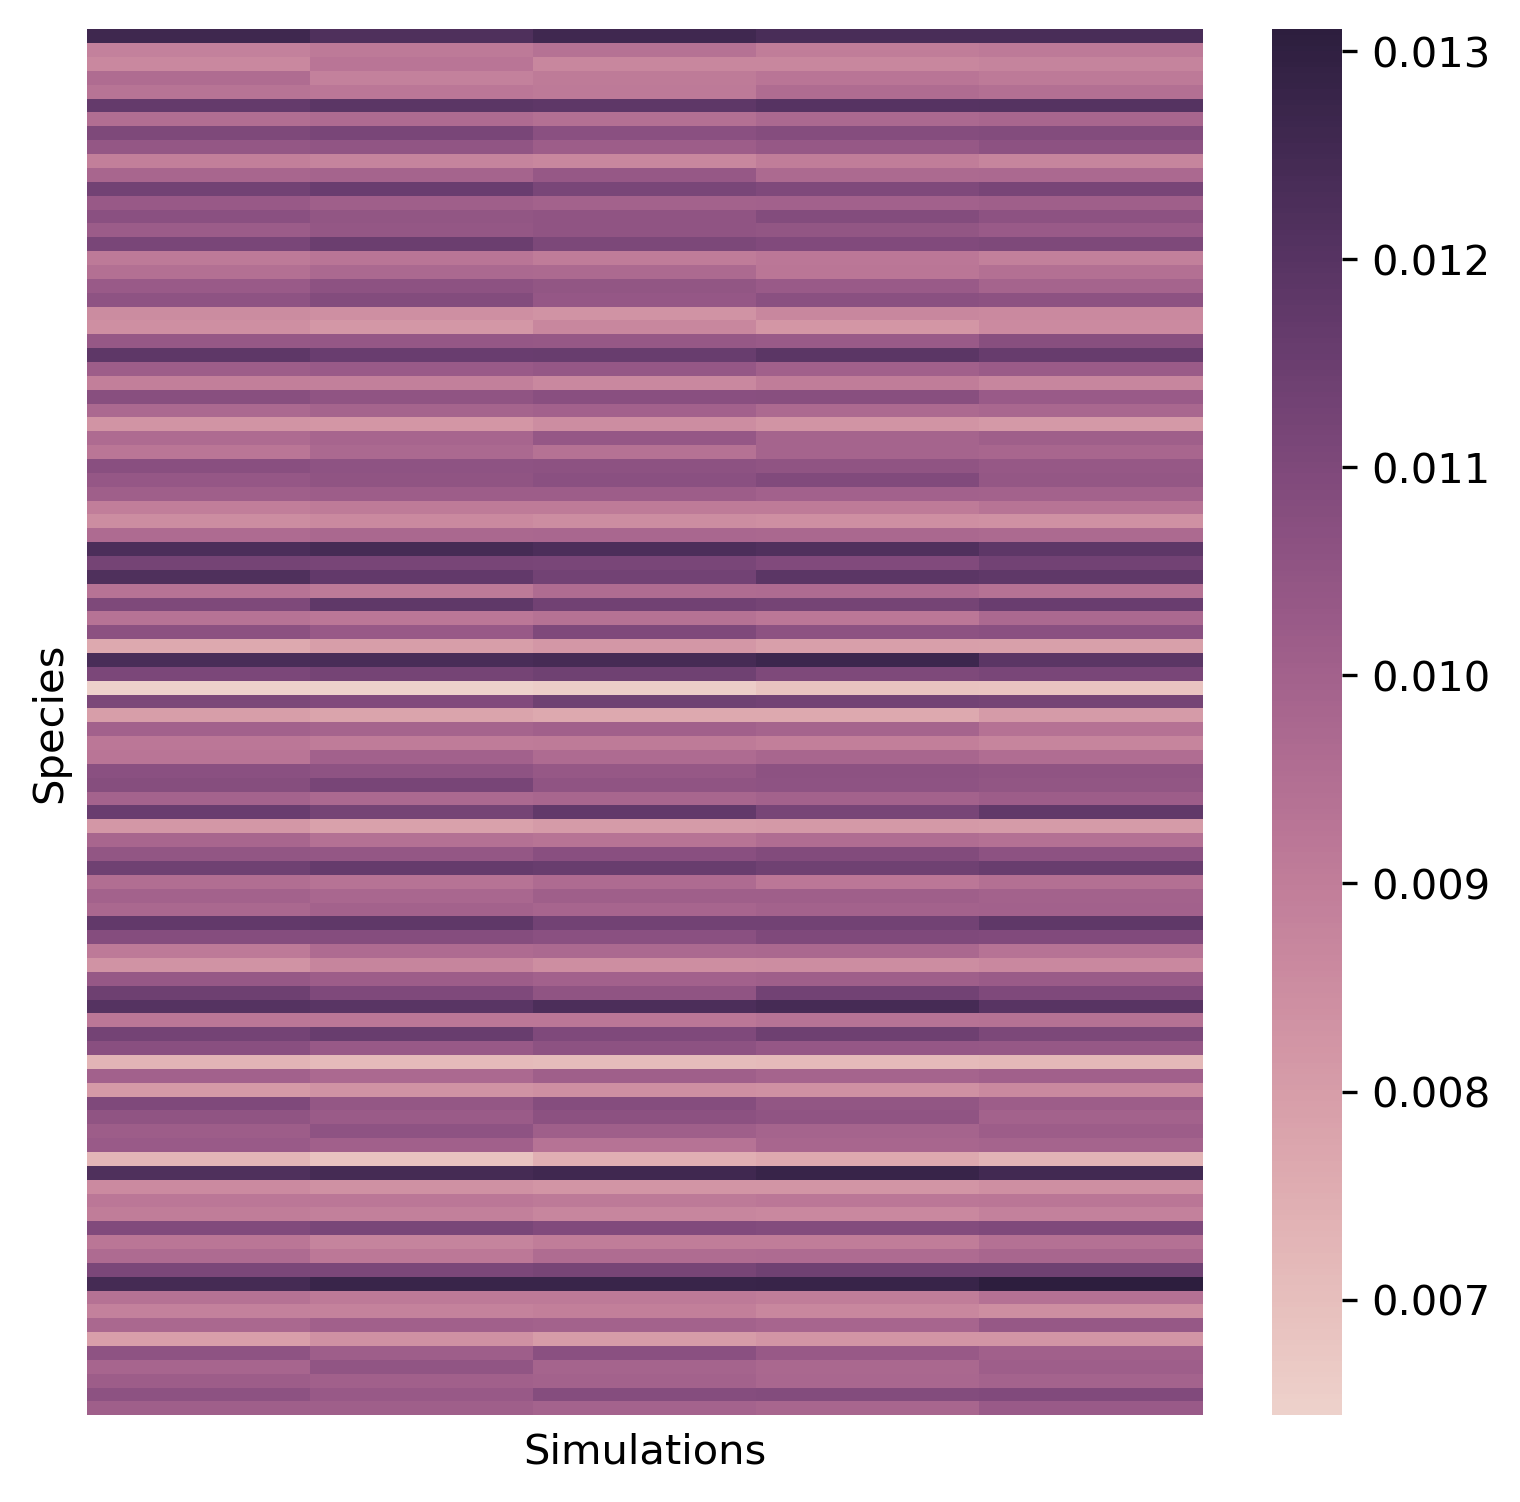

In [8]:
plt.figure(figsize=(6, 6), dpi=300)
sns.heatmap(abundance25, cmap=sns.cubehelix_palette(as_cmap=True)
, xticklabels=False, yticklabels=False)
plt.ylabel('Species')
plt.xlabel('Simulations')

Text(0.5, 181.33333333333331, 'Resource Type')

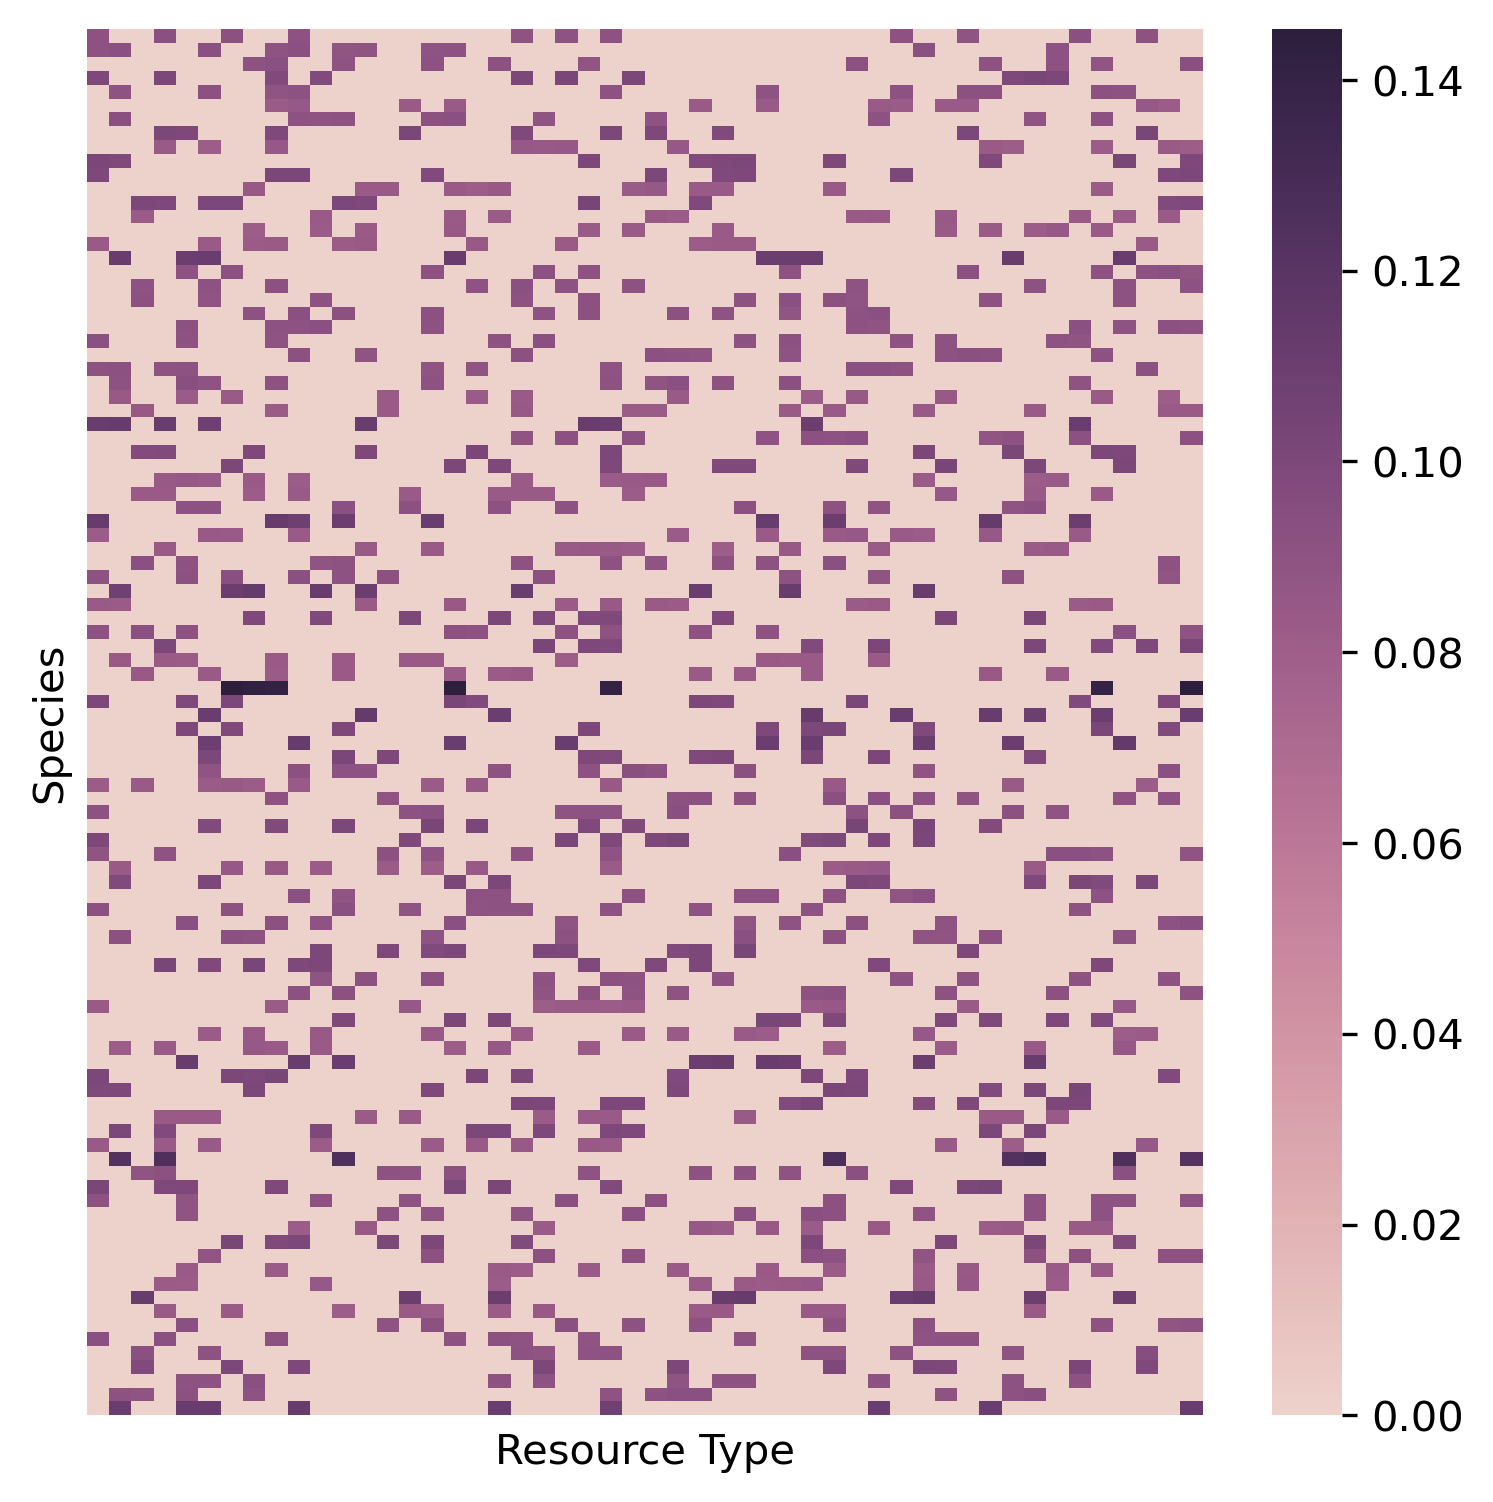

In [51]:
plt.figure(figsize=(6, 6), dpi=300)
sns.heatmap(para_assemblies[0].p, cmap=sns.cubehelix_palette(as_cmap=True)
, xticklabels=False, yticklabels=False)
plt.ylabel('Species')
plt.xlabel('Resource Type')

Text(0.5, 181.33333333333331, 'Output Resource')

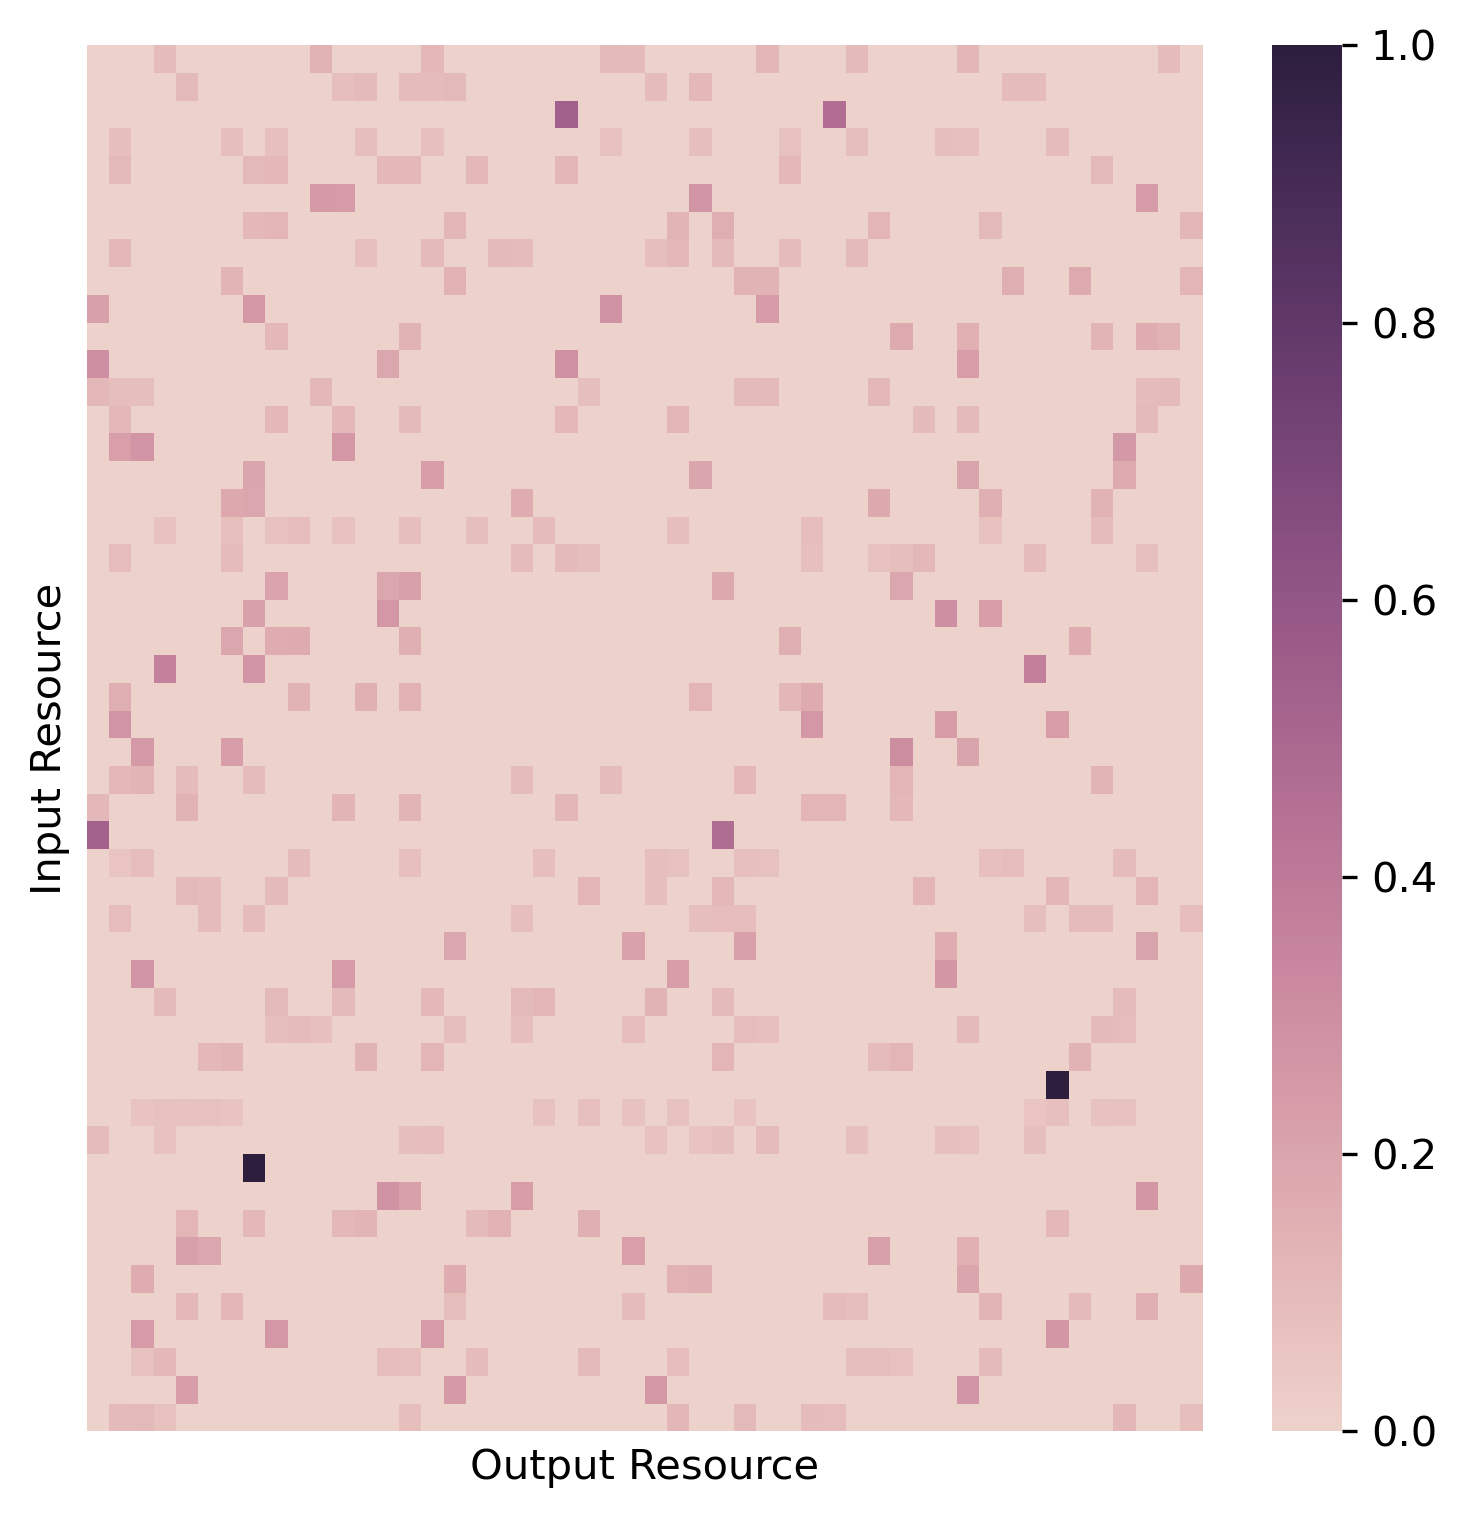

In [10]:
plt.figure(figsize=(6, 6), dpi=300)
sns.heatmap(para_assemblies[0].D, cmap=sns.cubehelix_palette(as_cmap=True)
, xticklabels=False, yticklabels=False)
plt.ylabel('Input Resource')
plt.xlabel('Output Resource')

### Ploting relative abundance v.s. size


### Plotting biomass distirbution at initial time and final time

In [11]:
# Extract the initial and final data
initial = np.full((N*assemlies), 1)
final = np.full((N*assemlies), 1)
for i in range(assemlies):
    model = para_assemblies[i]
    initial[i*N:(i+1)*N] = model.C.flatten()
    mass = Ct_assemblies[i]
    final[i*N:(i+1)*N] = mass[:, -1]

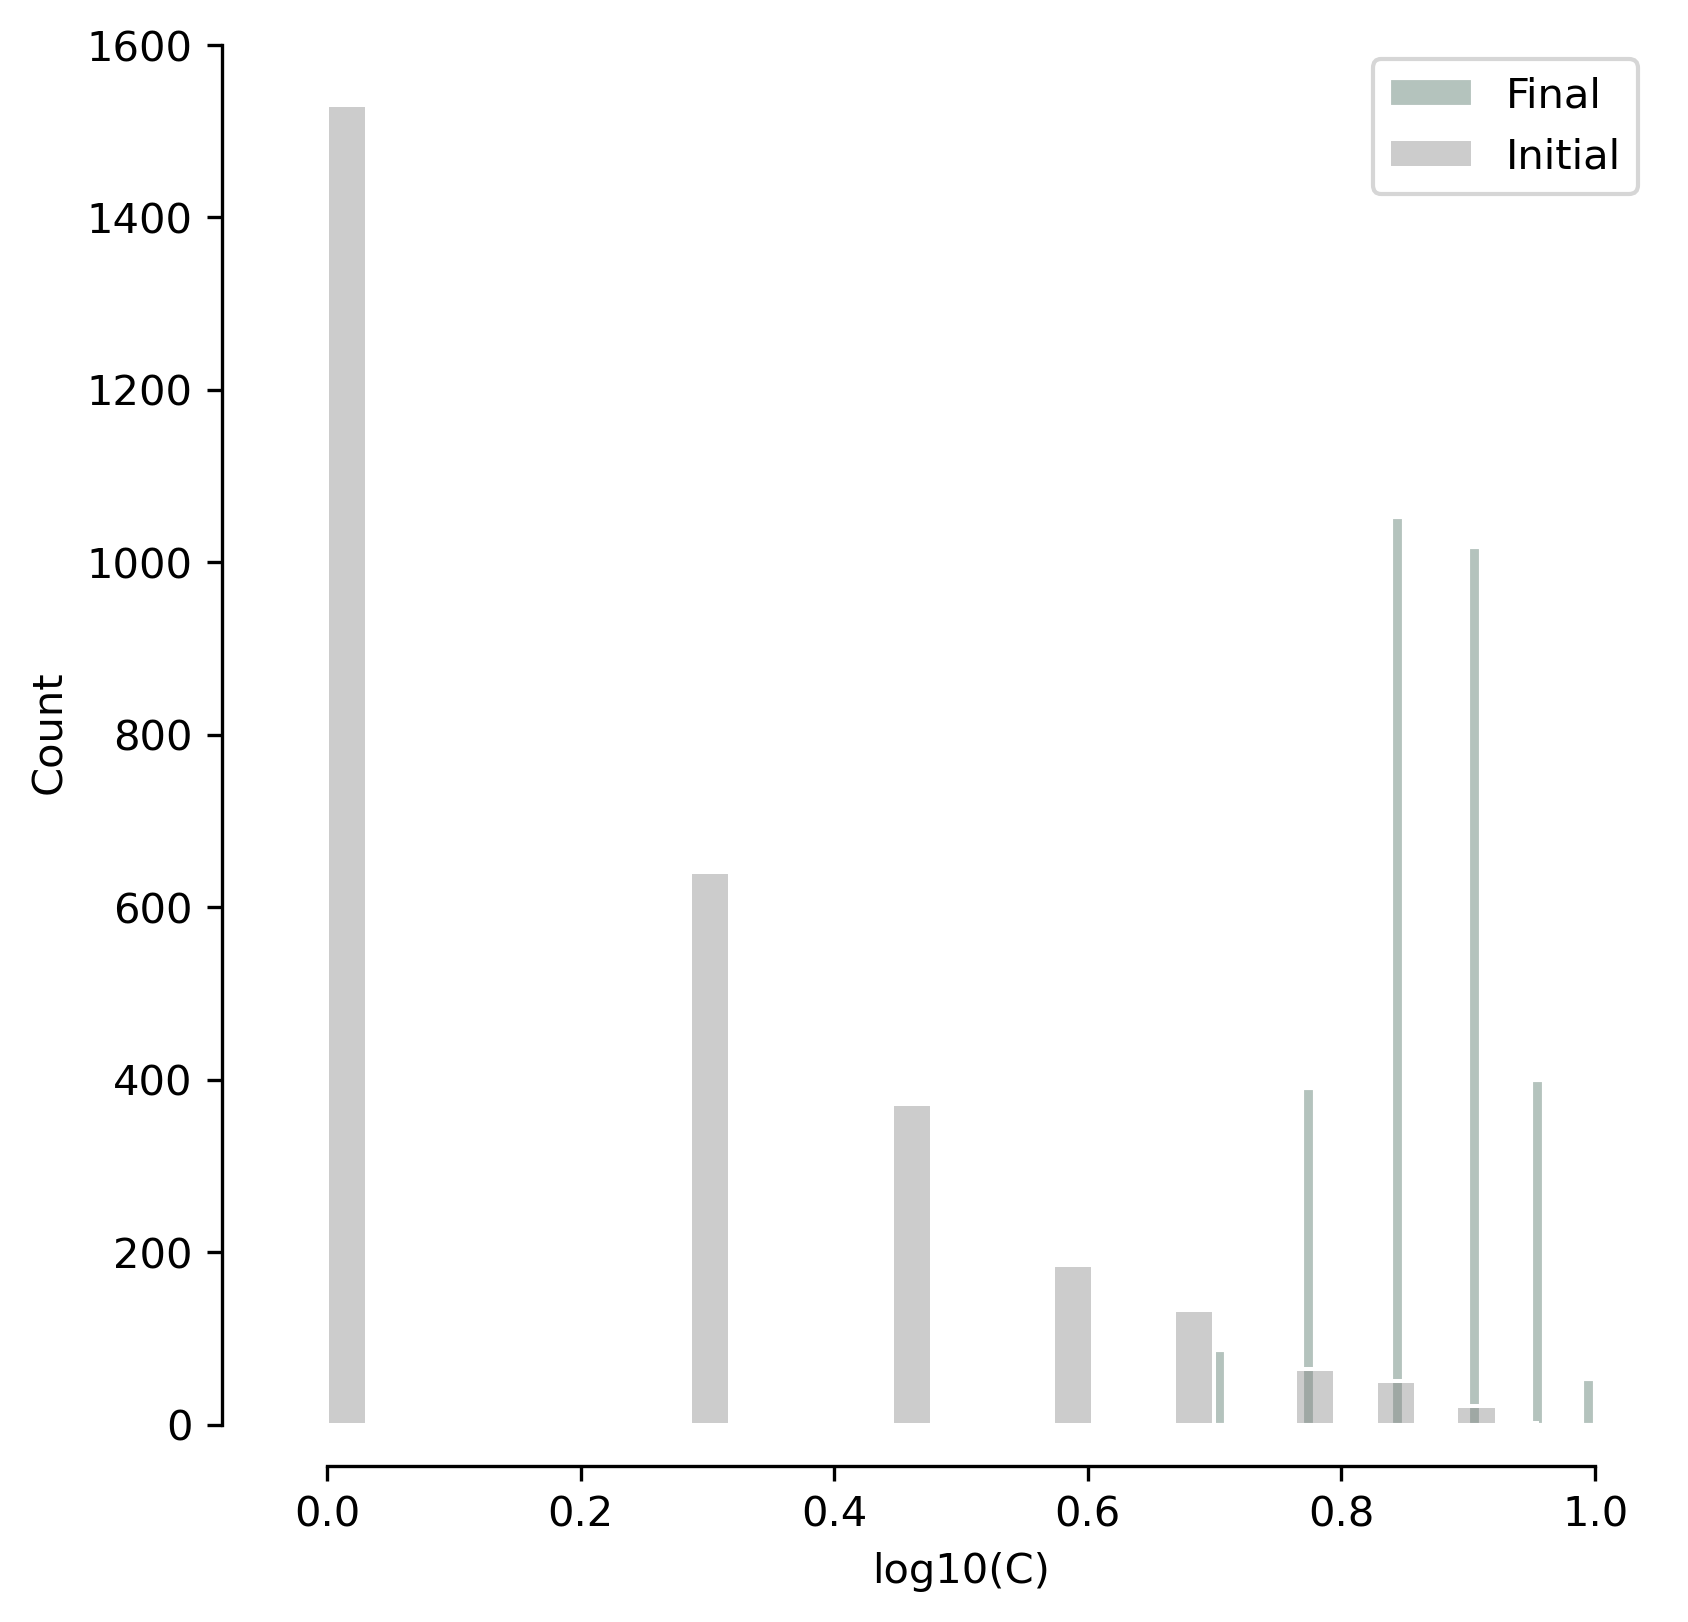

In [12]:
# Plot 
plt.figure(figsize=(6, 6), dpi=300)
sns.histplot(
    np.log10(final), label='Final', color='#456B5C', 
    bins=30, alpha=0.4,
    edgecolor='white')
sns.histplot(np.log10(initial), label='Initial', color='grey', 
             bins=30, alpha=0.4,
             edgecolor='white')
plt.legend()
plt.xlabel('log10(C)')
sns.despine(offset=10, trim=True)

In [13]:
species1vg = []
m1 = []
for i in range(len(t)):
    resourcet = Rt[:, i].reshape(M, 1)
    masst = Ct[:, i].reshape(N, 1)
    v_in = vin(para.p, resourcet, para.R_half, vmax=para.v_in_max, type=2)
    v_in = scale_vin(v_in, masst, para.B0, para.alpha)
    v_g = vgrow(v_in, para.l)
    # v_g = scale_vgrow(v_g, masst, para.B0, para.alpha)
    v_g = v_g * masst
    species1vg.append(v_g[1])
    m_scale = scale_mt(para.m, masst, para.M0, para.alpha)
    m_scale = m_scale * masst
    m1.append(m_scale[1])


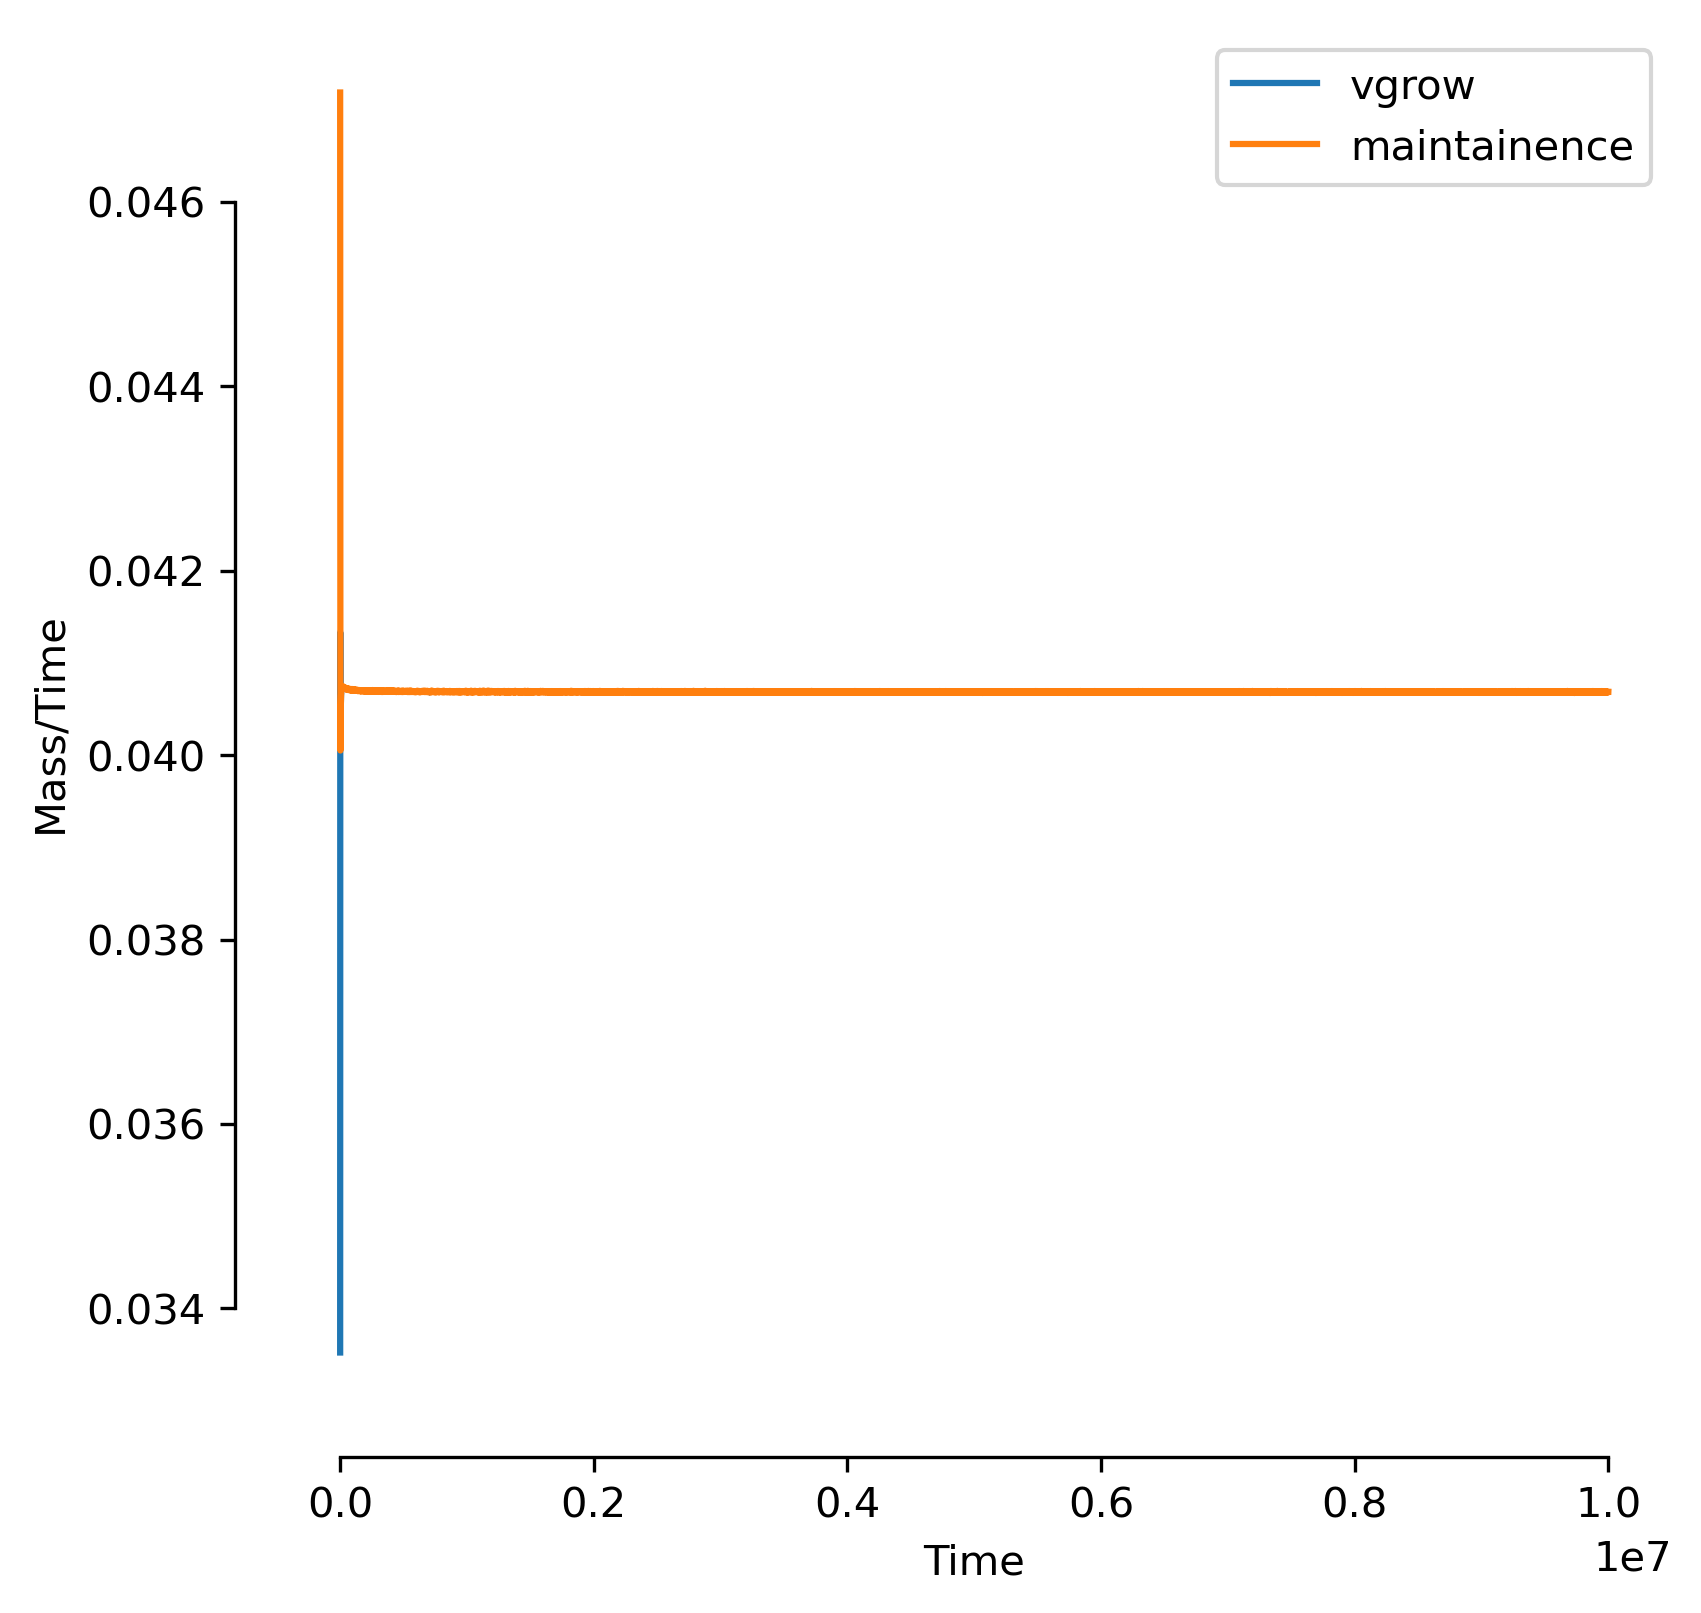

In [14]:
plt.figure(figsize=(6, 6), dpi=300)
plt.plot(t[0:700], species1vg[0:700], label = 'vgrow')
plt.plot(t, m1, label='maintainence')
plt.legend()
plt.ylabel('Mass/Time')
plt.xlabel('Time')
sns.despine(offset=10, trim=True)

### Relative abundance distribution at Final Time

In [15]:
spec_name = np.array([f'species {i}' for i in range(1, N+1)])
# df = pd.DataFrame({
#     'C':0,
#     'Species': 'Species 1'
# })
l = []
for i, item in enumerate(Ct_assemblies):
    temp = pd.DataFrame({'C':item[:, -1], 'Species': spec_name})
    l.append(temp)
result = pd.concat(l)
result.index = np.arange(len(result.iloc[:, 0]))

<Figure size 7500x7500 with 0 Axes>

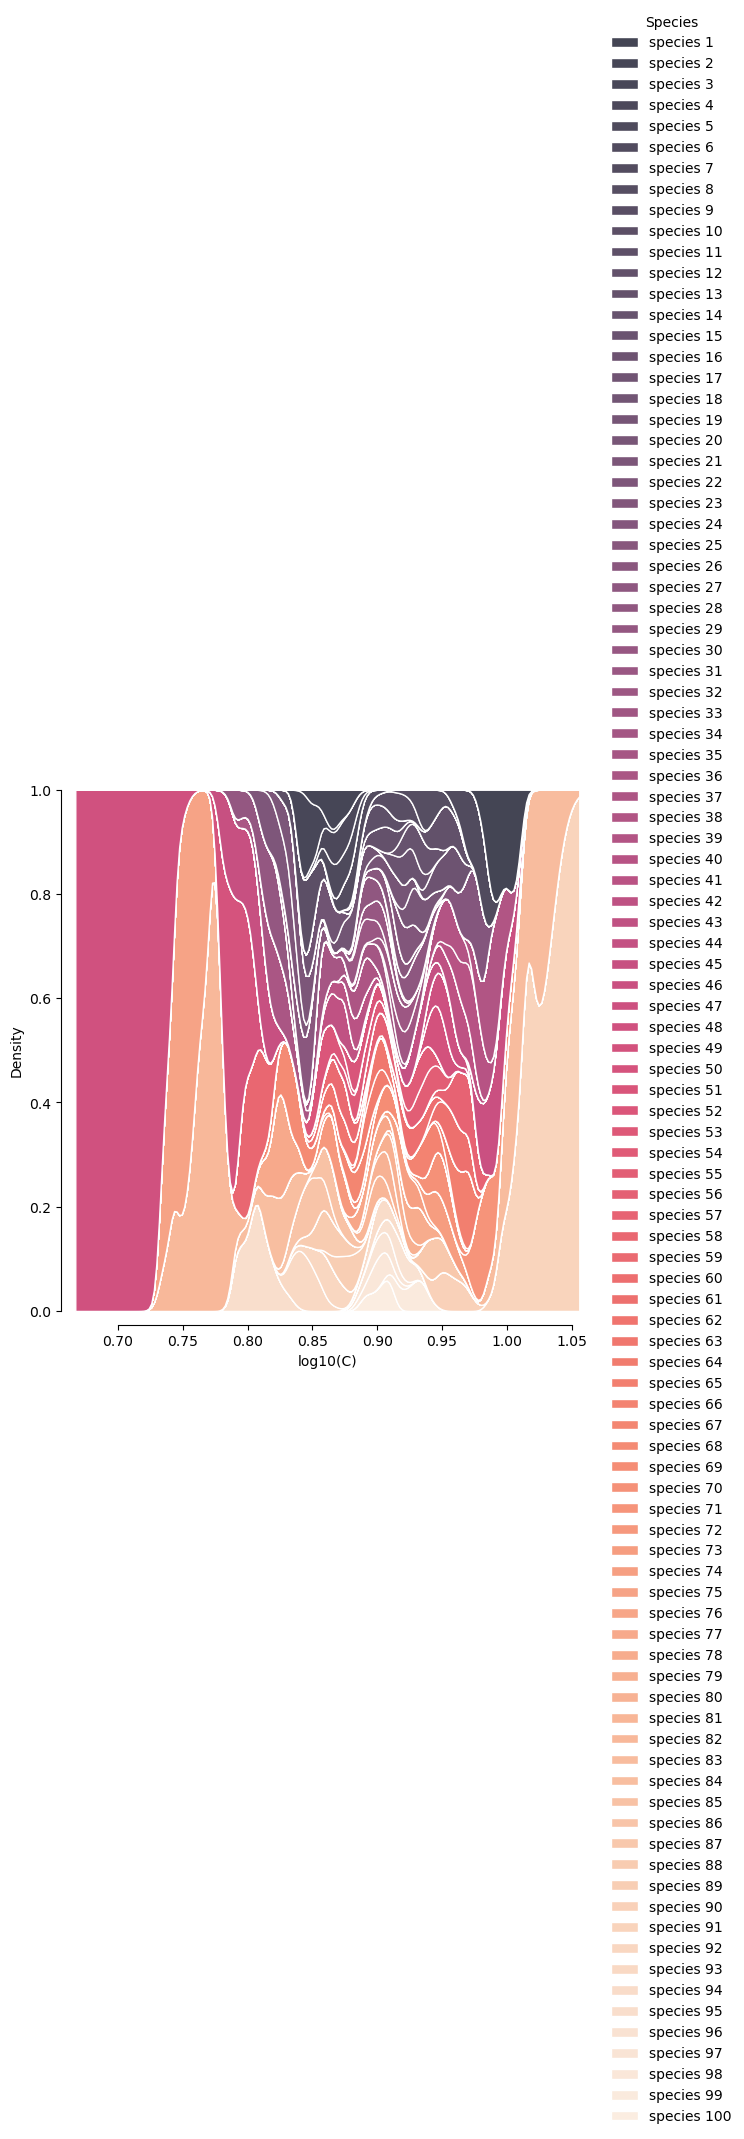

In [16]:
# biomass
plt.figure(figsize=(15, 15), dpi=500)
ax = sns.displot(
    data=result,
    x=np.log10(result['C']), hue="Species",
    kind="kde", height=6,
    multiple="fill", clip=(0, None),
    palette=sns.color_palette("rocket", N),
    edgecolor='white'
)

# sns.move_legend(ax, loc='right', bbox_to_anchor=(0, 0.5), ncol=2)
# plt.tight_layout()
plt.xlabel('log10(C)')
sns.despine(offset=10, trim=True)


<Figure size 1800x1800 with 0 Axes>

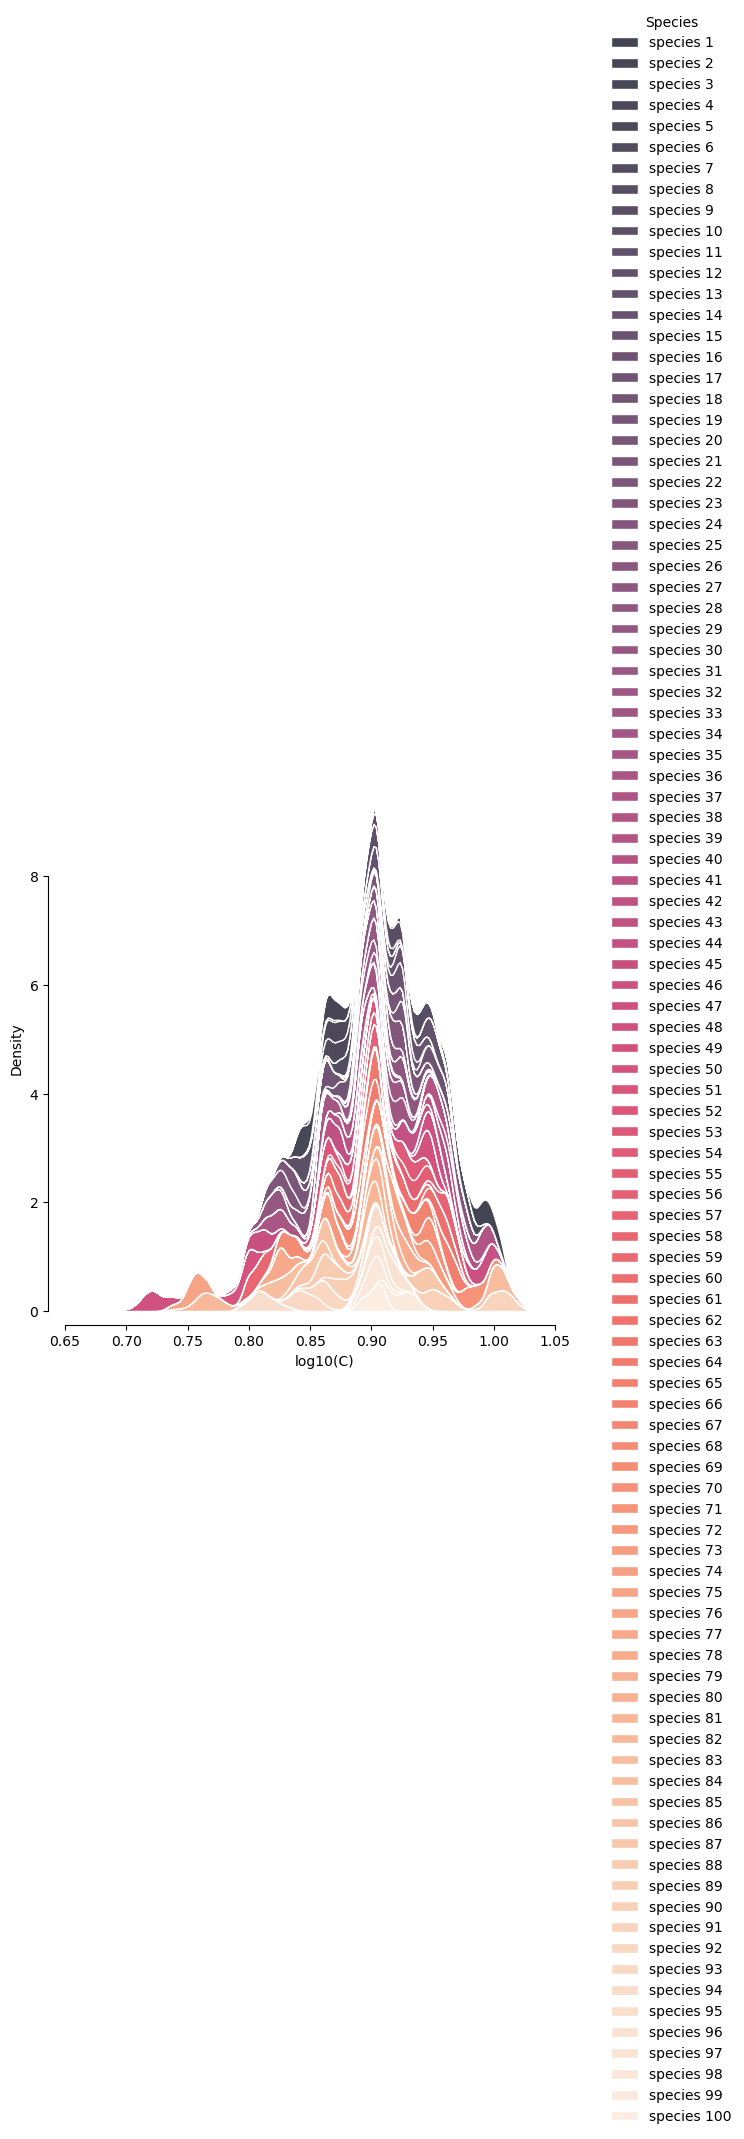

In [17]:
# biomass
plt.figure(figsize=(6, 6), dpi=300)
ax = sns.displot(
    data=result,
    x=np.log10(result['C']), hue="Species",
    kind="kde", height=6,
    multiple="stack", clip=(0, None),
    palette=sns.color_palette("rocket", N),
    edgecolor='white'
)
plt.xlabel('log10(C)')
# sns.move_legend(ax, loc='right', bbox_to_anchor=(0, 0.5), ncol=2)
# plt.tight_layout()
sns.despine(offset=10, trim=True)

In [18]:
spec_name = np.array([f'species {i}' for i in range(1, N+1)])
# df = pd.DataFrame({
#     'C':0,
#     'Species': 'Species 1'
# })
l2 = []
for i, item in enumerate(Ct_assemblies):
    temp = pd.DataFrame({'ad':item[:, -1]/np.sum(item[:, -1]), 'Species': spec_name})
    l2.append(temp)
result2 = pd.concat(l2)
result2.index = np.arange(len(result2.iloc[:, 0]))

<Figure size 3000x3000 with 0 Axes>

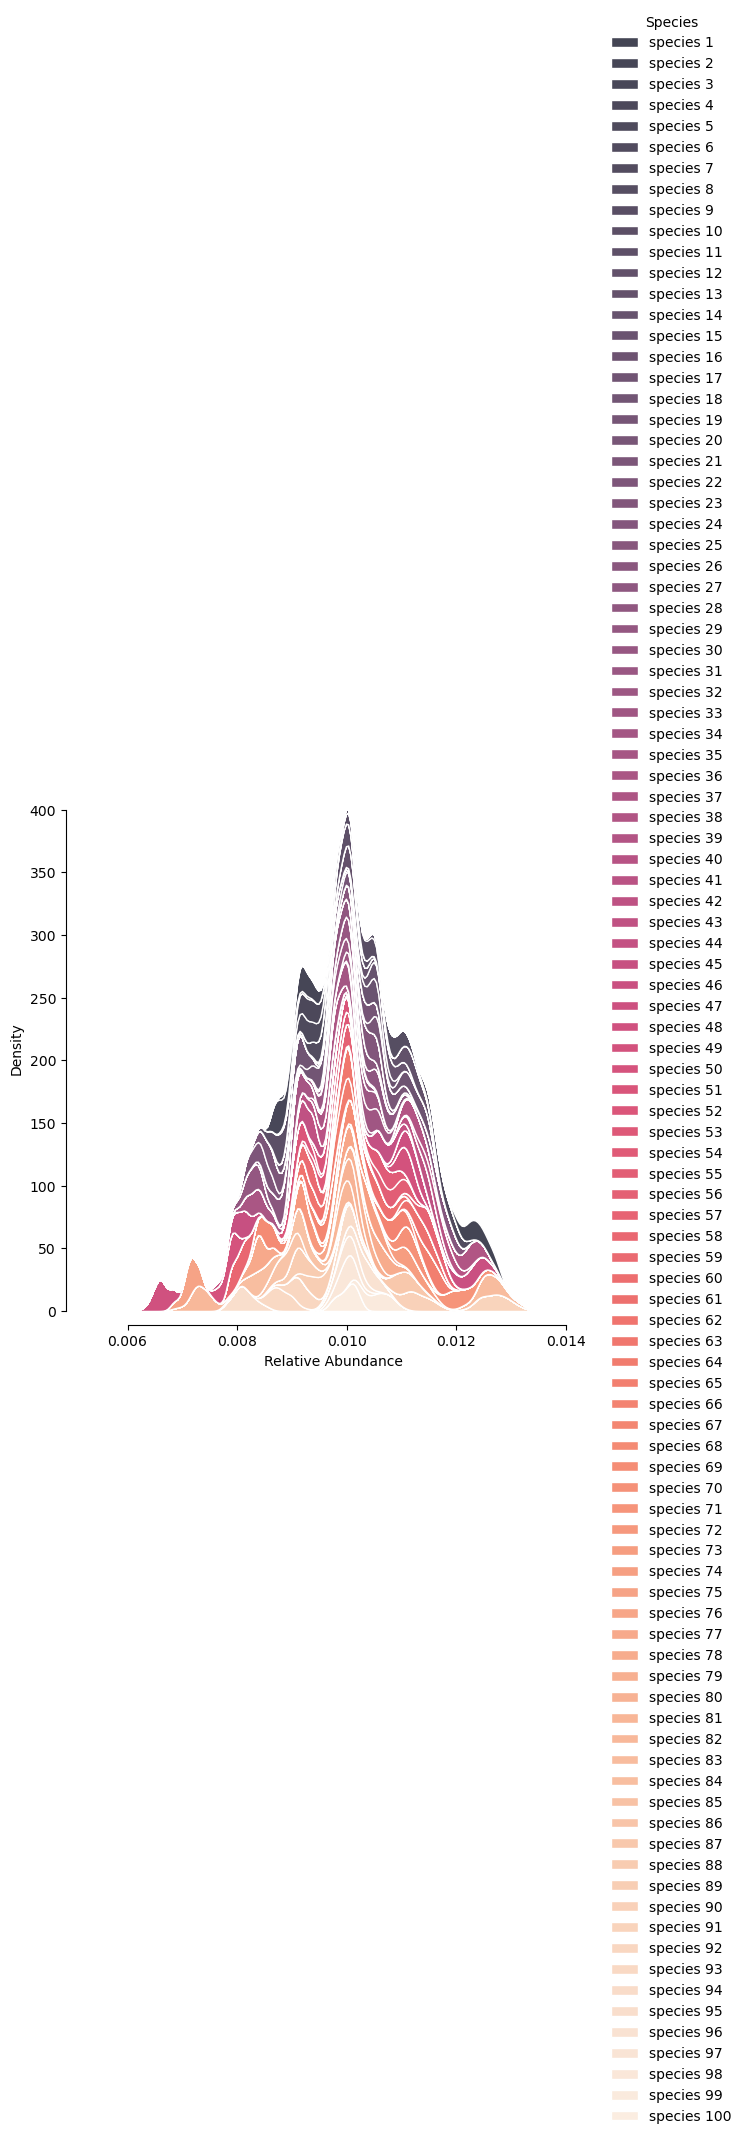

In [19]:
# biomass
plt.figure(figsize=(10, 10), dpi=300)
sns.displot(
    data=result2,
    x='ad', hue="Species",
    kind="kde", height=6,
    multiple="stack", clip=(0, None),
    palette=sns.color_palette("rocket", N),
    edgecolor='white'
)
plt.xlabel('Relative Abundance')
sns.despine(offset=10, trim=True)
# sns.move_legend(ax, loc='right', bbox_to_anchor=(0, 0.5), ncol=2)
# plt.tight_layout()

<Figure size 1800x1800 with 0 Axes>

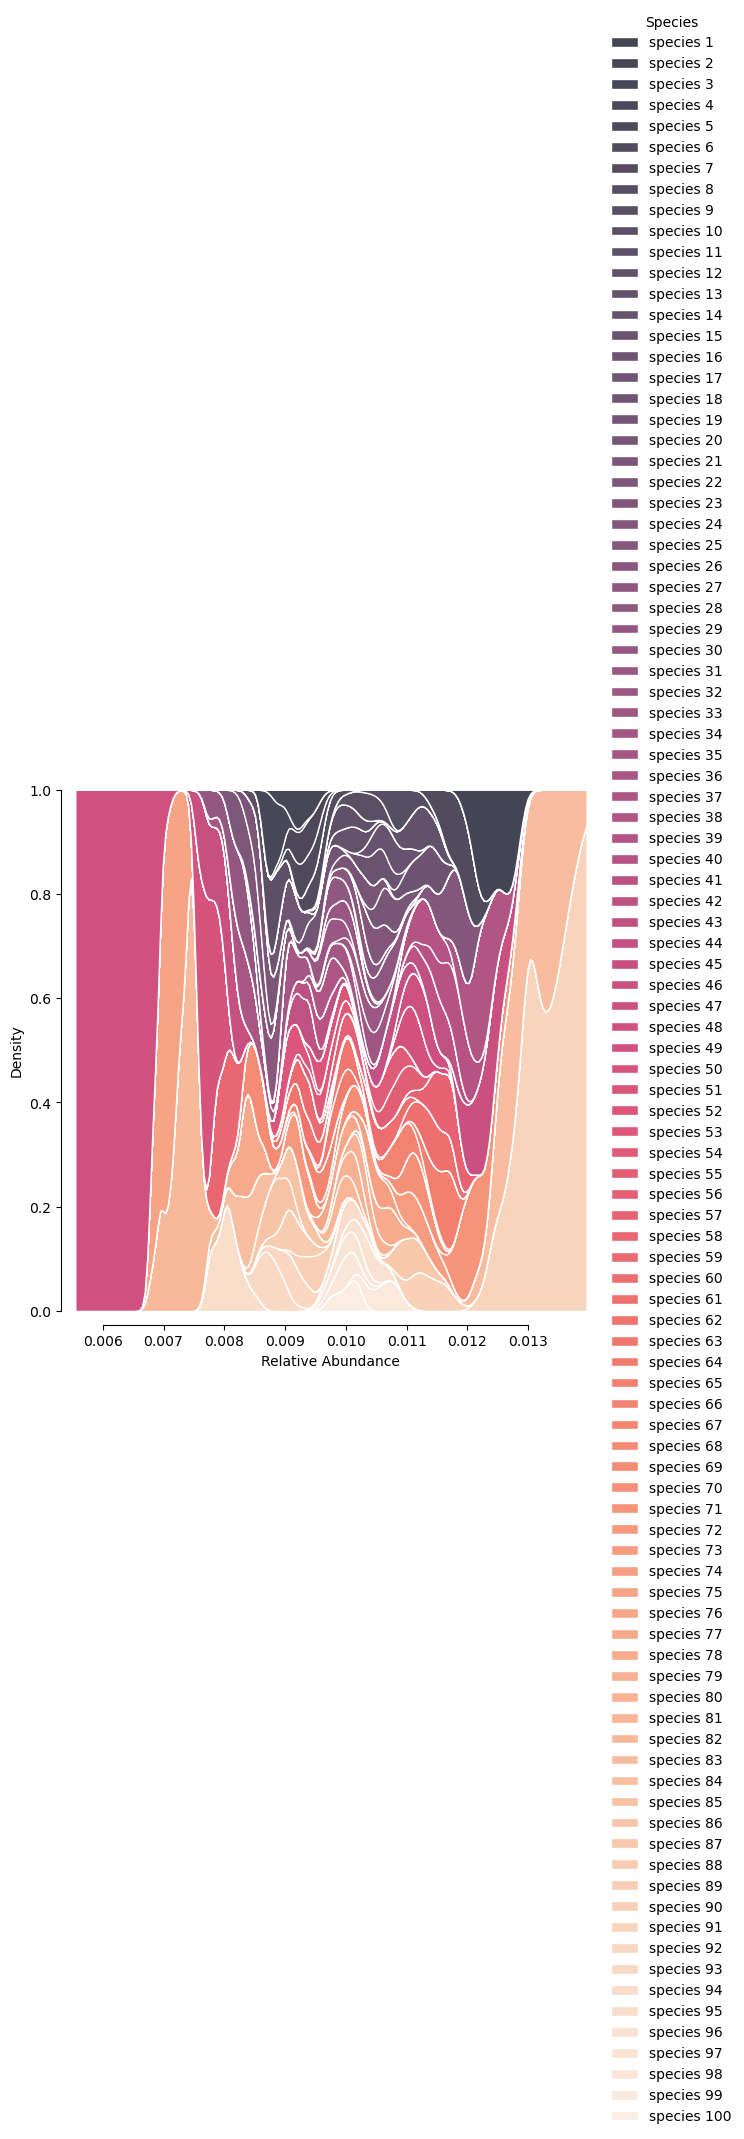

In [20]:
# biomass
plt.figure(figsize=(6, 6), dpi=300)
sns.displot(
    data=result2,
    x='ad', hue="Species",
    kind="kde", height=6,
    multiple="fill", clip=(0, None),
    palette=sns.color_palette("rocket", N),
    edgecolor='white'
)
plt.xlabel('Relative Abundance')
sns.despine(offset=10, trim=True)

## Visualise population trajectories

- Starts with absolute biomass
- Then Abundance

In [21]:
specn = 6

In [22]:
# Choose a representative assembly
repr_Ct = Ct_assemblies[specn]
repr_t = time_assemblies[specn]
repr_Rt = Rt_assemblies[specn]

In [23]:
repr_Rt.shape

(50, 10000)

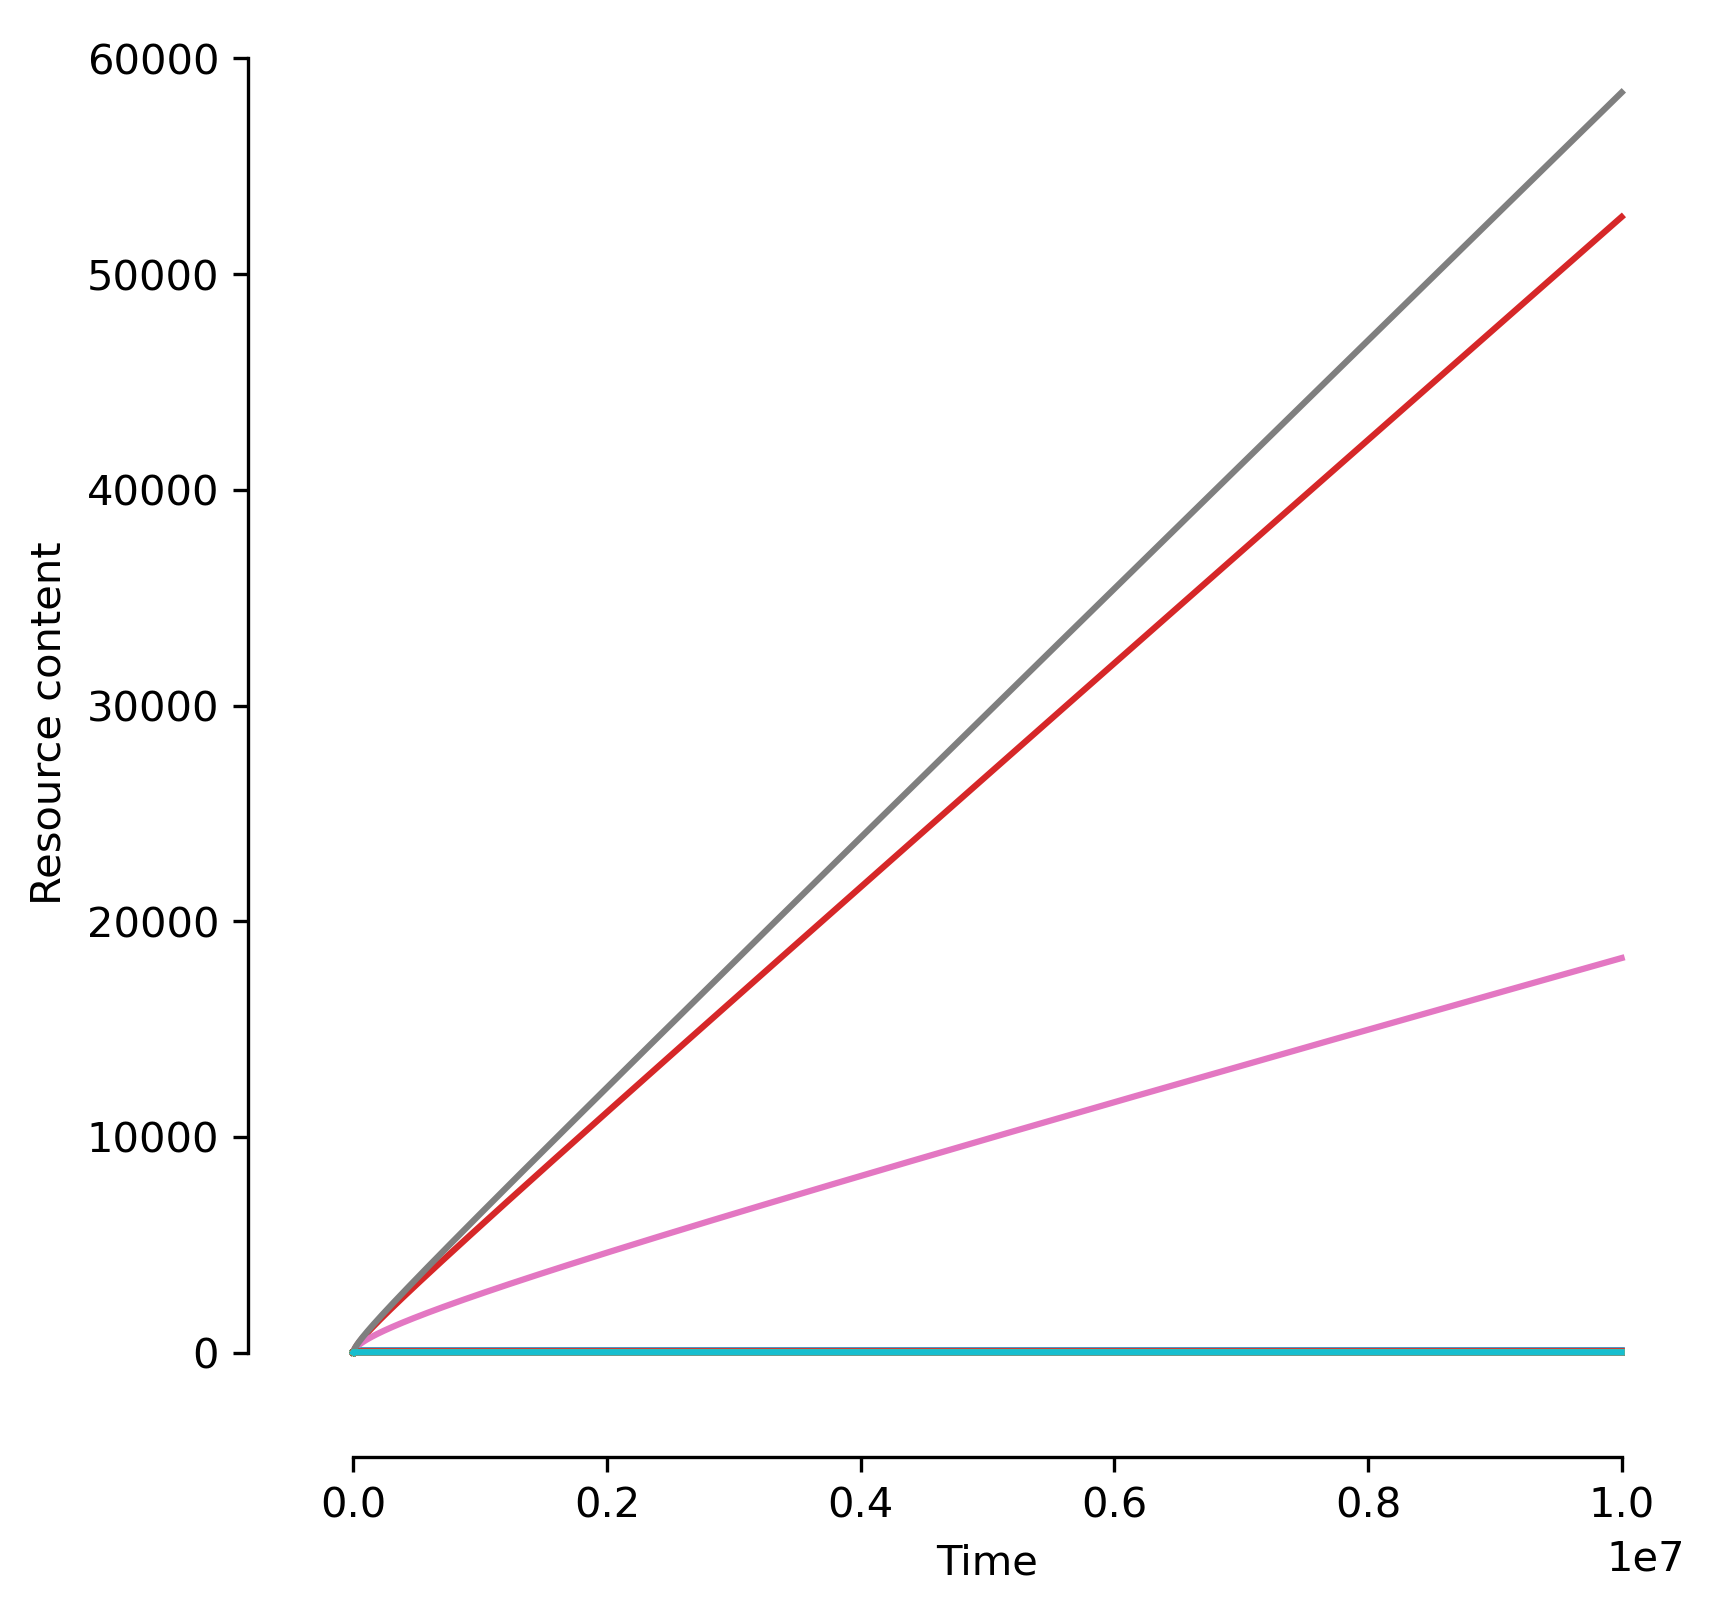

In [24]:
# plot species biomass trajectories
plt.figure(figsize=(6, 6), dpi=300)
for i in range(para.M):
    sns.lineplot(x=repr_t, y=repr_Rt[i, :])
plt.xlabel('Time')
plt.ylabel('Resource content')
sns.despine(offset=10, trim=True)

C:\Users\IVANN\AppData\Local\Temp\ipykernel_26784\4193129253.py:4: RuntimeWarning: divide by zero encountered in log10
  sns.lineplot(x=np.log10(repr_t), y=repr_Ct[i, :], color='grey', alpha=0.3)
C:\Users\IVANN\AppData\Local\Temp\ipykernel_26784\4193129253.py:4: RuntimeWarning: divide by zero encountered in log10
  sns.lineplot(x=np.log10(repr_t), y=repr_Ct[i, :], color='grey', alpha=0.3)
C:\Users\IVANN\AppData\Local\Temp\ipykernel_26784\4193129253.py:4: RuntimeWarning: divide by zero encountered in log10
  sns.lineplot(x=np.log10(repr_t), y=repr_Ct[i, :], color='grey', alpha=0.3)
C:\Users\IVANN\AppData\Local\Temp\ipykernel_26784\4193129253.py:4: RuntimeWarning: divide by zero encountered in log10
  sns.lineplot(x=np.log10(repr_t), y=repr_Ct[i, :], color='grey', alpha=0.3)
C:\Users\IVANN\AppData\Local\Temp\ipykernel_26784\4193129253.py:4: RuntimeWarning: divide by zero encountered in log10
  sns.lineplot(x=np.log10(repr_t), y=repr_Ct[i, :], color='grey', alpha=0.3)
C:\Users\IVANN\AppDa

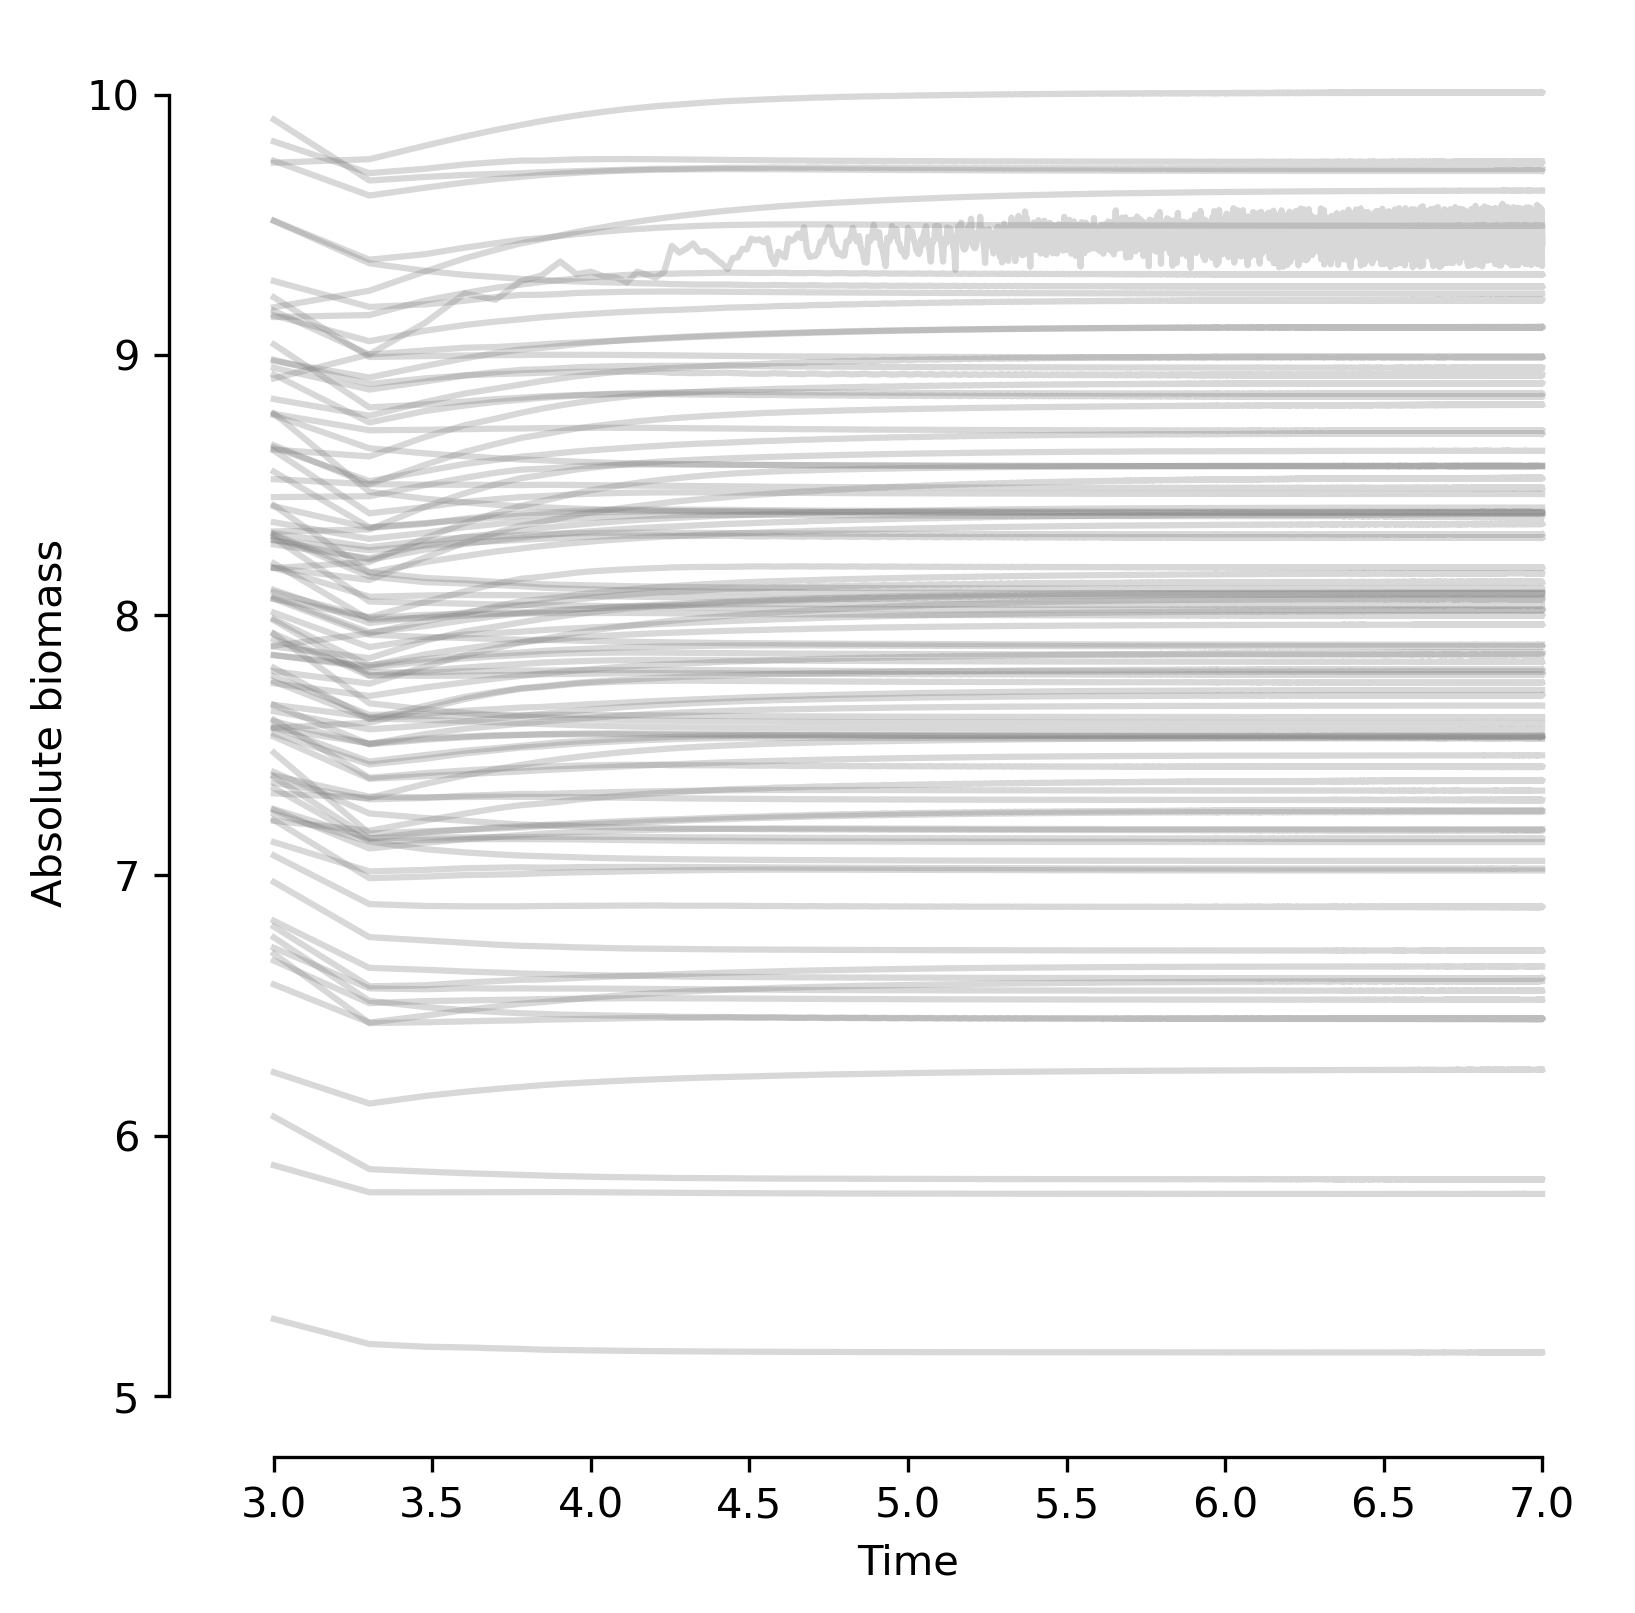

In [25]:
# plot species biomass trajectories

plt.figure(figsize=(6, 6), dpi=300)
for i in range(N):
    sns.lineplot(x=np.log10(repr_t), y=repr_Ct[i, :], color='grey', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Absolute biomass')
sns.despine(offset=10, trim=True)

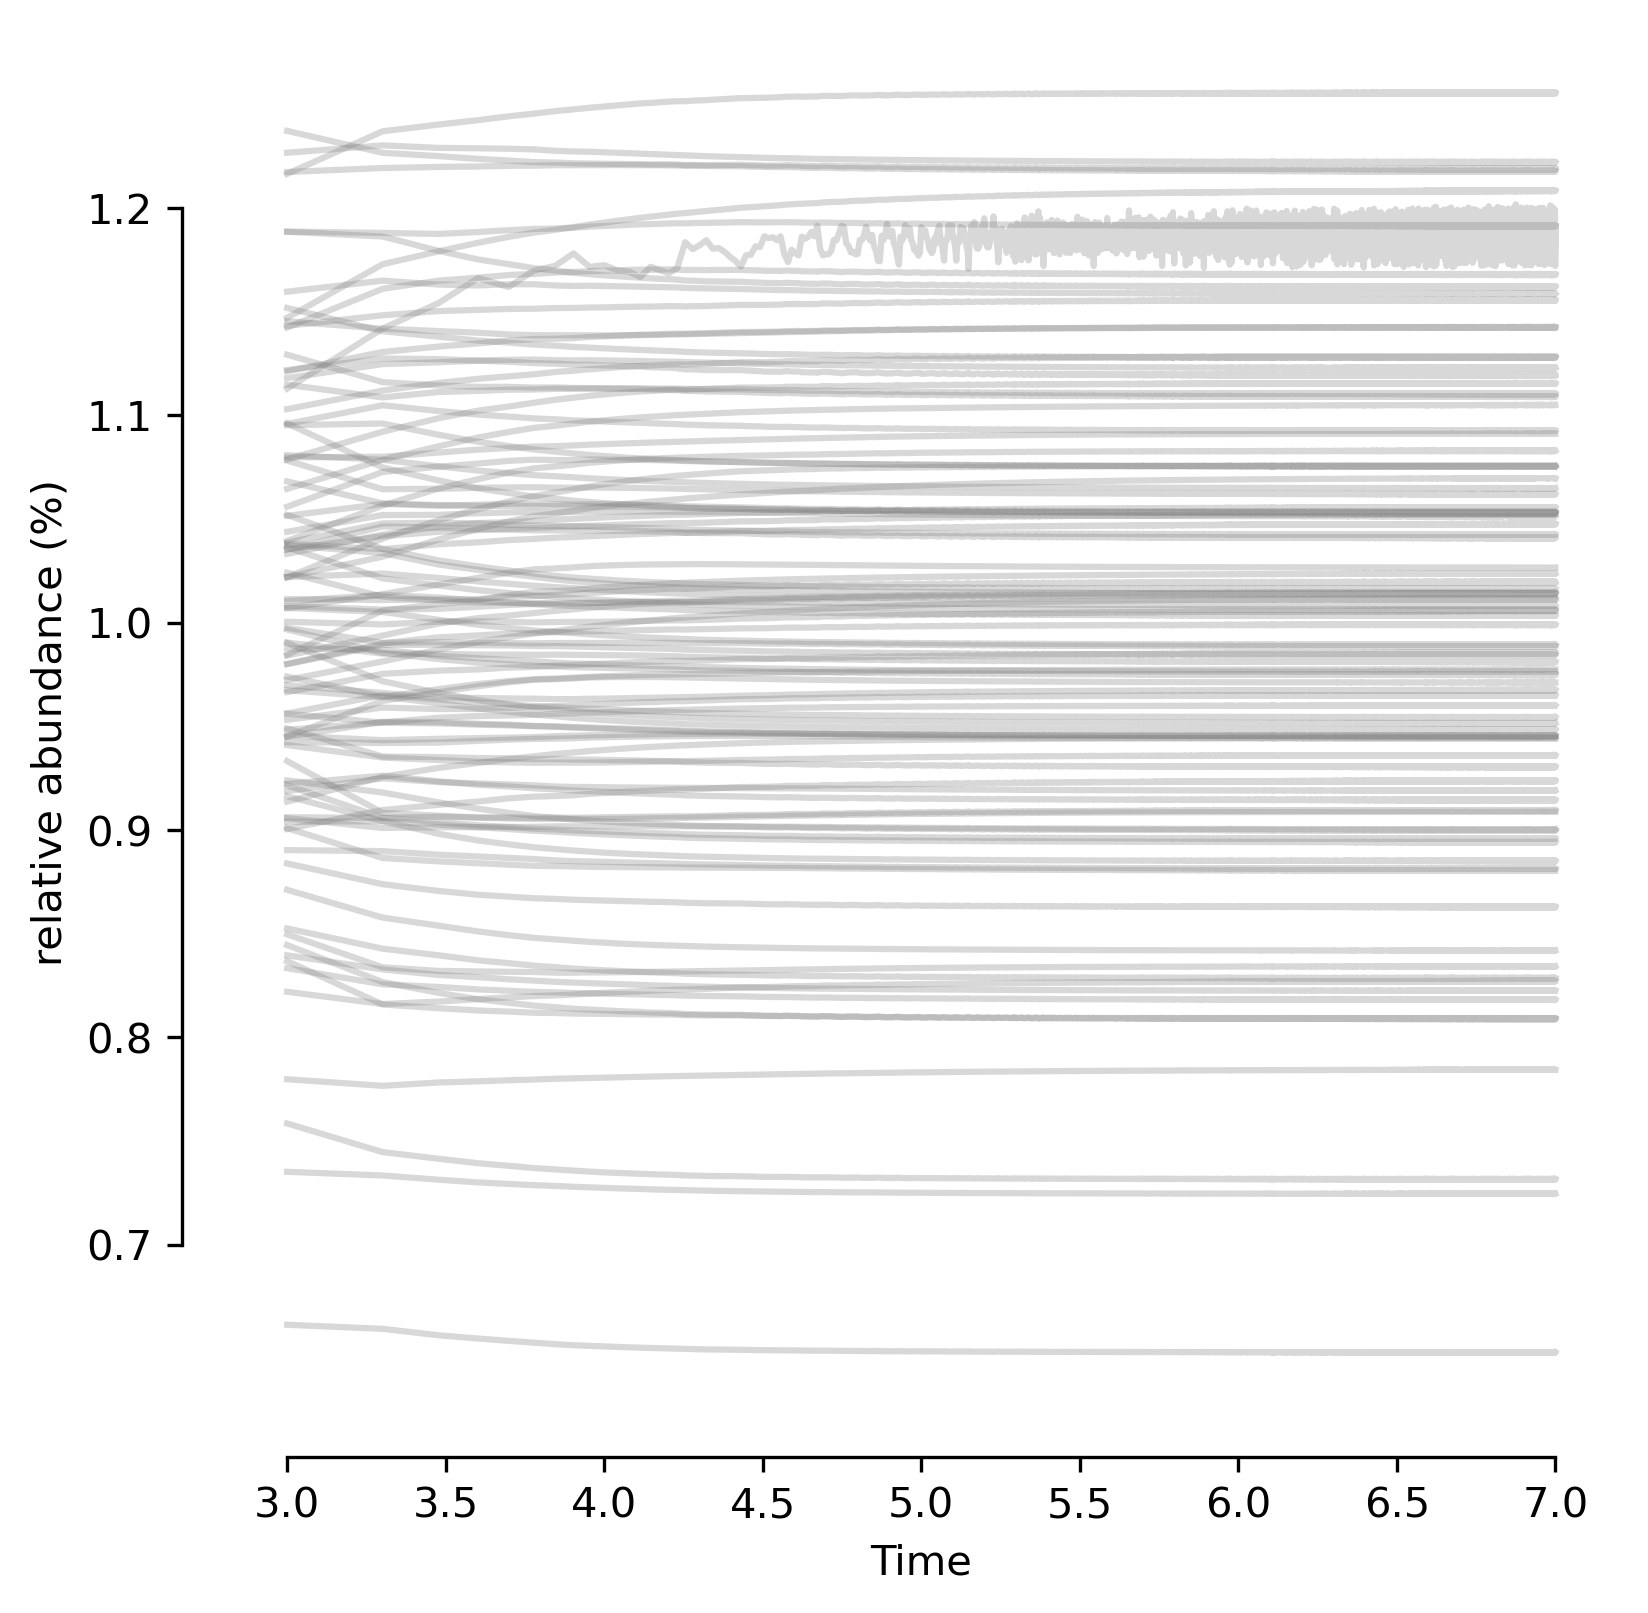

In [52]:
# plot species abudance trajectories
np.seterr(divide = 'ignore')
plt.figure(figsize=(6, 6), dpi=300)
for i in range(N):
    sns.lineplot(x=np.log10(repr_t), y=relative_abundance(repr_Ct)[i, :]*100,color='grey', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('relative abundance (%)')
sns.despine(offset=10, trim=True)

In [27]:
a = relative_abundance(repr_Ct)[:, -1]*100
b = relative_abundance(Ct_assemblies[1])[:, -1]*100

In [28]:
np.dot(a/np.linalg.norm(a), b/np.linalg.norm(b))

0.9996108840362214

## Create Association matricies

- Given the nature of Non-linear dynamics of relative abundance, pairwise spearman's correlation is used for create association matricies
- Starts with one assemblies first
- Select a time window, w, for correlation, w=100
    - with a stride s = 5
    - ranging from t=0 to t=2000
- Correlation matrix for one assemblies
    - $N \times N \times [(100/5)*(2000/100)]$

In [29]:
from scipy.stats import spearmanr
from scipy.stats import permutation_test

In [30]:
# extract assemblies time series
cdata = Ct_assemblies[1]
cdata = cdata[:, 0:5000]
cdata.shape

(100, 5000)

In [31]:
M, p = pairwise_spearmanr(cdata[:,0:100])

Text(0.5, 181.33333333333331, 'Species')

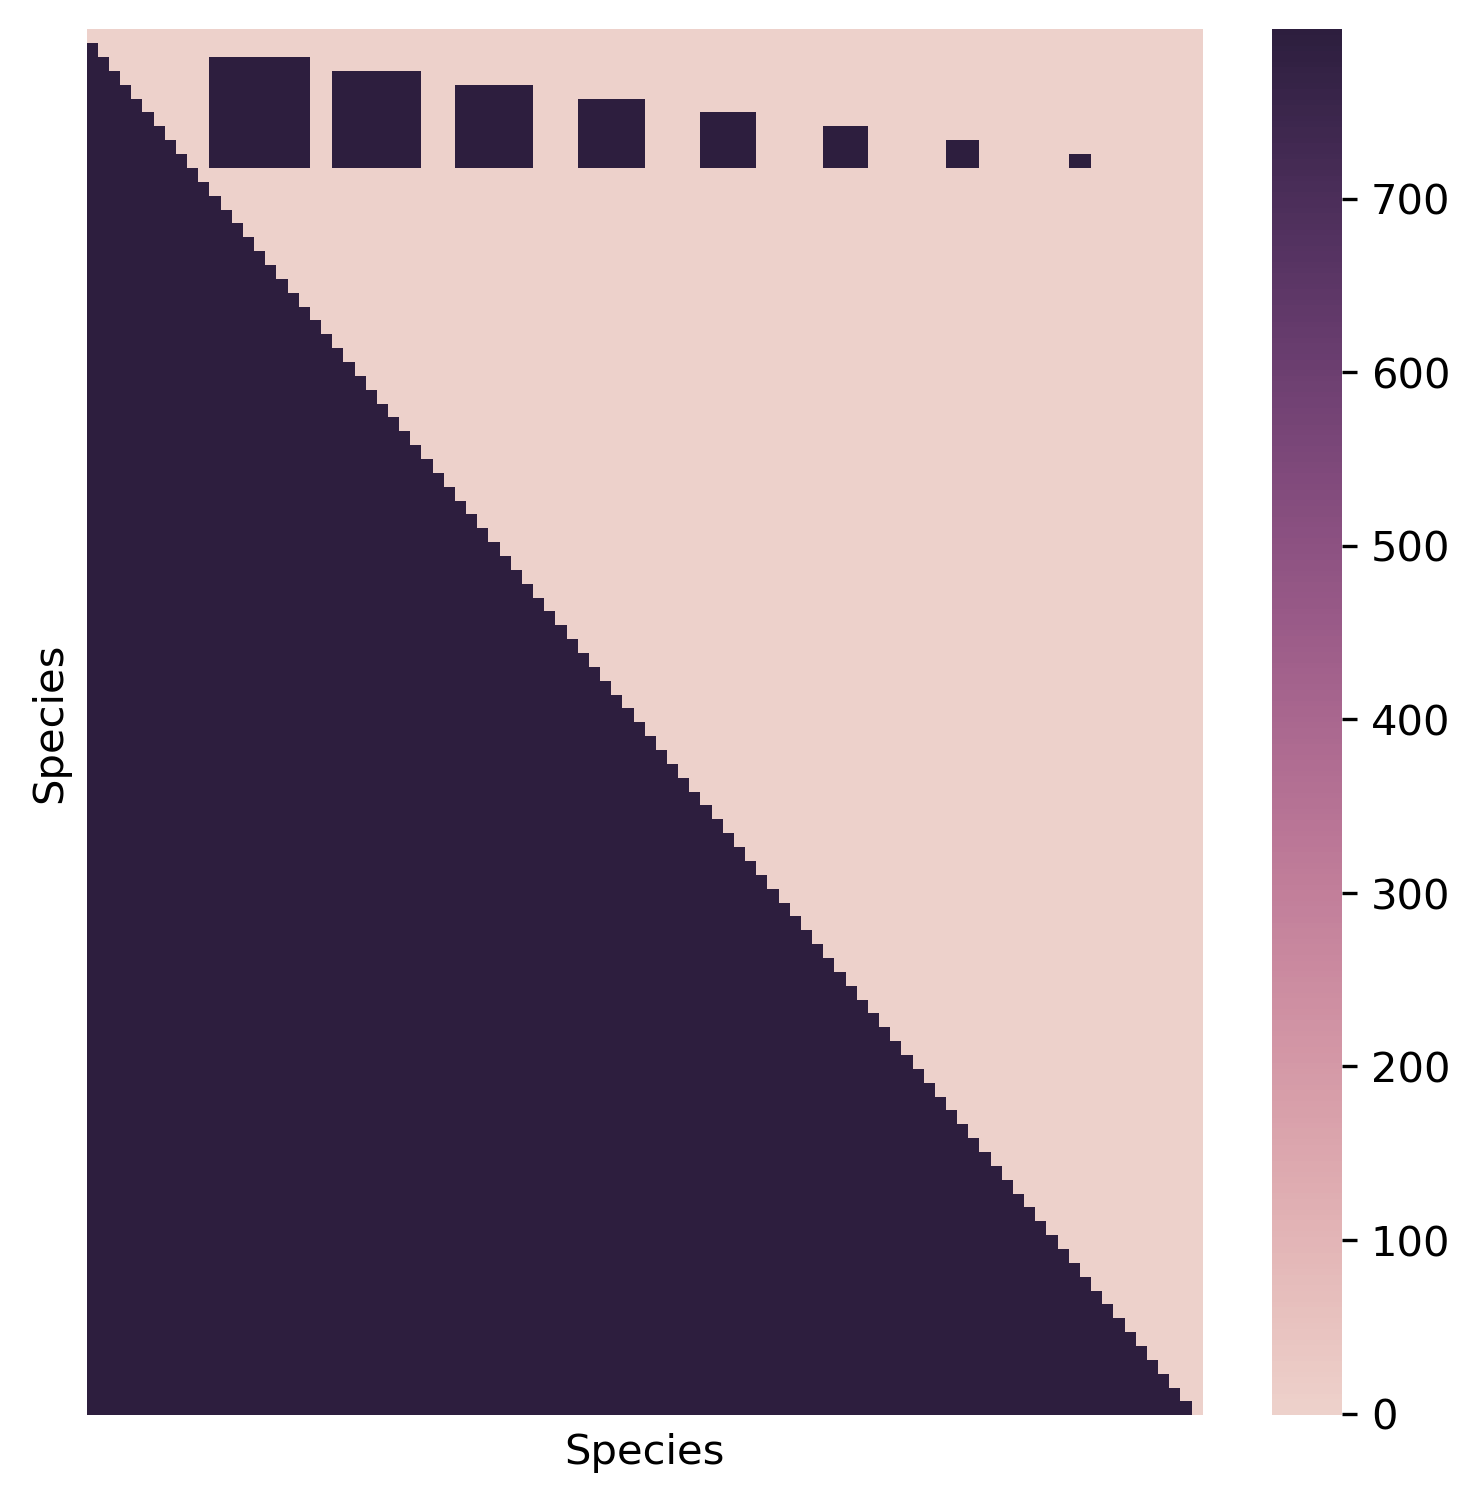

In [32]:
plt.figure(figsize=(6, 6), dpi=300)
sns.heatmap(M, cmap=sns.cubehelix_palette(as_cmap=True)
, xticklabels=False, yticklabels=False)
plt.ylabel('Species')
plt.xlabel('Species')

In [33]:
seriesM, seriesP = assocation_series(cdata, w=100, s=5, tstarts=0, tstop=2000)

KeyboardInterrupt: 

## Network Analysis

In [ ]:
import networkx as nx
import matplotlib as mpl

In [ ]:
%matplotlib

Using matplotlib backend: <object object at 0x00000287ADA523B0>


- Graphs generation

In [ ]:
def make_graphs(series):
    G_list = []
    for i in range(len(series[0, 0, :])):
        temp = series[:, :, i]
        temp[np.isnan(series[:, :, i])] = 0
        G_list.append(nx.from_numpy_array(temp, ))
    return G_list

In [ ]:
Glist = make_graphs(seriesM)

In [ ]:
G = Glist[156]
plt.figure(figsize=(6, 6), dpi=600)
widths = nx.get_edge_attributes(G, 'weight')
layout = nx.spring_layout(G, seed=7)
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
options = {
        'node_size': 10,
        'edgelist': edges,
        'edge_color':weights,
        'alpha': 0.4,
        "width": list(widths.values()),
        "edge_cmap": plt.cm.Blues,
        'edge_vmin': -1, 
        'edge_vmax': 1
}
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
nx.draw(G, layout, **options)

plt.box(False)

In [ ]:
from community import community_louvain
import matplotlib.cm as cm

In [ ]:
seriesM.shape

(100, 100, 380)

In [ ]:
def plot_partition_graph(series, t):
    plt.figure(figsize=(6, 6), dpi=600)
    G = nx.from_numpy_array(series[:, :, t])
    widths = nx.get_edge_attributes(G, 'weight')
    partition = community_louvain.best_partition(G)
    layout = nx.spring_layout(G, seed=7)
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    nx.draw_networkx_nodes(
        G, layout, partition.keys(), node_size=10, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, layout, alpha=0.1, width=list(widths.values()))
    plt.box(False)

In [ ]:
def plot_graph_series(series, tstarts, tstop):
    for i in range(tstarts, tstop):
        plt.figure(figsize=(6, 6), dpi=600)
        G = nx.from_numpy_array(series[:, :, i])
        widths = nx.get_edge_attributes(G, 'weight')
        partition = community_louvain.best_partition(G)
        layout = nx.spring_layout(G, seed=7)
        cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
        nx.draw_networkx_nodes(
            G, layout, partition.keys(), node_size=10, cmap=cmap, node_color=list(partition.values()))
        nx.draw_networkx_edges(G, layout, alpha=0.1, width=list(widths.values()))
        plt.box(False)

## Investigating Abundance State Profiles

- Using Isomap for visualising the trajectories for each assemblies by setting
    - embedding sepecies abundance maybe in 3 dimension
    - track the trajectories of state profiles and plot
    - should converge to the same point

In [ ]:
from sklearn.manifold import Isomap


In [ ]:
# extract data
datamat = extract_Ct_multiple(Ct_assemblies)

In [ ]:
nsample = 20

In [ ]:
embseries_val = np.empty((nsample, 3, 2000))
embseries_error = np.empty((nsample, 3, 2000))
for i in range(len(datamat[0, 0:2000, 0])):
    model = Isomap(n_components=3, n_neighbors=2) # initialised model
    temp = datamat[:, i, 0:nsample].T
    embseries_val[:, :, i] = model.fit_transform(temp)
    embseries_error[:, :, i] = model.reconstruction_error()

f:\Anaconda3\envs\fyp\lib\site-packages\sklearn\manifold\_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
f:\Anaconda3\envs\fyp\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
f:\Anaconda3\envs\fyp\lib\site-packages\sklearn\manifold\_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
f:\Anaconda3\envs\fyp\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row

In [ ]:
# get ready for 3D plot
# we need time series of x, y, z for one example
x, y, z = np.empty((2000, nsample)), np.empty((2000, nsample)), np.empty((2000, nsample))

for i in range(nsample):
    x[:, i], y[:, i], z[:, i] = embseries_val[i, 0, :].T, embseries_val[i, 1, :].T, embseries_val[i, 2, :].T


#### Plotting trajectories

In [ ]:
# plt.figure(figsize=(14, 14), dpi=100)
ax = plt.axes(projection='3d')
for i in range(nsample):
    ax.plot3D(x[:, i], y[:, i], z[:, i])
    ax.text(x[0, i], y[0, i], z[0, i], s='start')
    ax.text(x[-1, i], y[-1, i], z[-1, i], s='end')
    # rotate the axes and update
for angle in range(0, 360):
    ax.view_init(30, 40)
sns.despine()

: 